In [19]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
from line_profiler import LineProfiler
from contextlib import redirect_stdout
import matplotlib.patches as mpatches
jax.config.update("jax_enable_x64", True)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### THE ITERATION PARAMETERs
#physical parameters
delta = 0.008 #interface width
Lambda = jnp.sqrt(2)*delta/4

gamma_ab = 1e-2 #interface energy between components A,B
gamma_bc = 1.8e-2
gamma_ca = 1e-2
gamma = jnp.array([gamma_ab, gamma_bc, gamma_ca])

if gamma_bc < 1e-2:
    Aa = (9*gamma_ab + 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
    Ab = (9*gamma_ab - 12*(gamma_ca - gamma_bc))/(4*jnp.sqrt(2)*Lambda)
    Ac = 3*jnp.sqrt(2)*gamma_ca/Lambda - 4*Aa/3 - Ab/3 
else:
    Ab = jnp.sqrt(2)*(9*gamma_bc + 12*(gamma_ab - gamma_ca))/(8*Lambda)
    Ac = jnp.sqrt(2)*(9*gamma_bc - 12*(gamma_ab - gamma_ca))/(8*Lambda)
    Aa = 3*jnp.sqrt(2)*gamma_ab/Lambda - 4*Ab/3 - Ac/3


A = jnp.array([Aa, Ab, Ac])

C = jnp.max(A + jnp.roll(A, 1))/6

print(jnp.sqrt(2)*Lambda*(Aa + Ab + 2*C)/6)
print(jnp.sqrt(2)*Lambda*(Ac + Ab + 2*C)/6)
print(jnp.sqrt(2)*Lambda*(Aa + Ac + 2*C)/6)

R = 0.3 #a circular droplet of phase b and c, with radius r = 1/3

#numerical parameters
stepmax = 6000000 # max number of iterations
tol = 1e-8 # parameter used as stopping criterion
h = 1e-6 # time-step (limited by the ODE step but independent of n1)
N = 512 #num of nodes
eps = 1e-13 

#meshigird
l = 1
dr = l/N
r = jnp.linspace(0, l, N+1)
r_mid = (r[1:] + r[:-1]) / 2
rx, ry = jnp.meshgrid(r_mid, r_mid)

#频率空间的网格
k = 2*jnp.pi*jnp.fft.fftfreq(N, d=dr)
kx, ky = jnp.meshgrid(k, k)
k_square = kx**2 + ky**2

0.010000000000000002
0.018000000000000002
0.010000000000000002


True
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


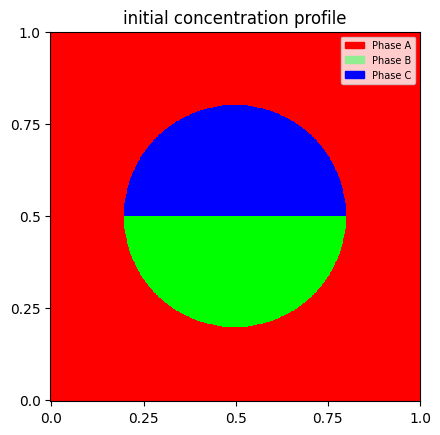

In [20]:
#the initial profile
def initial(interface):

    ua = jnp.full((N, N), 1.0)
    ub = jnp.zeros((N, N))
    uc = jnp.zeros((N, N))

    d = (rx - 0.5)**2 + (ry - 0.5)**2
    CircleCheck = d<jnp.power(R, 2)
    ua = jnp.where(CircleCheck, 0, ua)
    ub = jnp.where(CircleCheck, 1.0, ub)
    uc = jnp.where(CircleCheck, 1.0, uc)

    SemiCheck_up = ry>interface
    SemiCheck_low = ry<interface
    ub = jnp.where(SemiCheck_up, 0, ub)
    uc = jnp.where(SemiCheck_low, 0, uc)
    return ua, ub, uc

ua, ub, uc = initial(interface=0.5)
print(jnp.all(ua + ub + uc == 1))
print(ua + ub + uc)

#draw the concentration profile
def plot_RGB(ua, ub, uc, name, issavefig, show):
    u = jnp.stack((ua, ub, uc), axis=2)
    plt.figure()
    plt.gca().set_aspect('equal')
    plt.imshow(u, interpolation='nearest', origin='lower')
    plt.title(name)
    plt.xticks(ticks=jnp.linspace(1, N, 5), labels=jnp.linspace(0, 1, 5))
    plt.yticks(ticks=jnp.linspace(1, N, 5), labels=jnp.linspace(0, 1, 5))

    patch1 = mpatches.Patch(color='red', label='Phase A')
    patch2 = mpatches.Patch(color='lightgreen', label='Phase B')
    patch3 = mpatches.Patch(color='blue', label='Phase C')
    plt.legend(handles=[patch1, patch2, patch3], loc='upper right', prop={'size': 7})
    
    if issavefig == True:
        save_dir = f"result-new-new/gammaBC-{gamma_bc}"
        save_path = os.path.join(save_dir, f"{name}.pdf")
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_path)
    if show == True: plt.show()

plot_RGB(ua, ub, uc, name=f"initial concentration profile", issavefig=True, show=True)

In [21]:
#compute the interface chemical potential
@jax.jit
def cal_ChemicalPotential(i, u, S, P):
    mu = 2*A[i]*u*(1 - u)*(1 - 2*u) + 2*C*(u*(S - u**2) - (1-u)*(P + eps)/(jnp.power(1-u, 2) + eps))
    return mu

#FFT to Fourier space
@jax.jit
def pde_solver_FFT(ua, ub, uc):
    ua_hat = jnp.fft.fft2(ua)
    ub_hat = jnp.fft.fft2(ub)
    uc_hat = jnp.fft.fft2(uc)

    S = ua**2 + ub**2 +uc**2
    P = jnp.power(1-ua, 2)*jnp.power(1-ub, 2)*jnp.power(1-uc, 2)

    mu_a_hat = jnp.fft.fft2(cal_ChemicalPotential(0, ua, S, P))
    mu_b_hat = jnp.fft.fft2(cal_ChemicalPotential(1, ub, S, P))
    mu_c_hat = jnp.fft.fft2(cal_ChemicalPotential(2, uc, S, P))

    ua_hat_new = (ua_hat - h*k_square*mu_a_hat) / (1 + h*jnp.power(Lambda, 2)*(A[0] + C)*jnp.power(k_square, 2))
    ub_hat_new = (ub_hat - h*k_square*mu_b_hat) / (1 + h*jnp.power(Lambda, 2)*(A[1] + C)*jnp.power(k_square, 2))
    uc_hat_new = (uc_hat - h*k_square*mu_c_hat) / (1 + h*jnp.power(Lambda, 2)*(A[2] + C)*jnp.power(k_square, 2))

    ua_new = jnp.fft.ifft2(ua_hat_new).real
    ub_new = jnp.fft.ifft2(ub_hat_new).real
    uc_new = jnp.fft.ifft2(uc_hat_new).real

    return ua_new, ub_new, uc_new

dh = (4e-6 - h)/(stepmax/100000)
def main_loop(ua, ub, uc):
    global h
    for step in range(stepmax):
        ua0 = ua
        ub0 = ub
        uc0 = uc
        ua, ub, uc = pde_solver_FFT(ua, ub, uc)
        if step%100000==0: 
            h += dh
            err = (jnp.linalg.norm(ua - ua0) + jnp.linalg.norm(ub - ub0) + jnp.linalg.norm(uc - uc0)) / 3
            print(f"iteration {step} has done, err {err}")
    return ua, ub, uc

In [22]:
lp = LineProfiler()
func = lp(main_loop)
ua, ub, uc = func(ua, ub, uc)
print(ua + ub + uc)

iteration 0 has done, err 17.29307610341766
iteration 100000 has done, err 0.0007745307155277971
iteration 200000 has done, err 0.0005812819970319466
iteration 300000 has done, err 0.000453093882092834
iteration 400000 has done, err 0.0003575954999812509
iteration 500000 has done, err 0.0002854035602591286
iteration 600000 has done, err 0.0002303570519984297
iteration 700000 has done, err 0.00018781125725831935
iteration 800000 has done, err 0.00015430124374710816
iteration 900000 has done, err 0.00012762779557959052
iteration 1000000 has done, err 0.0001061376839677954
iteration 1100000 has done, err 8.880543207932259e-05
iteration 1200000 has done, err 7.443412676762605e-05
iteration 1300000 has done, err 6.273731591103762e-05
iteration 1400000 has done, err 5.299647799445279e-05
iteration 1500000 has done, err 4.477271438344989e-05
iteration 1600000 has done, err 3.8001884682876054e-05
iteration 1700000 has done, err 3.236624247000613e-05
iteration 1800000 has done, err 2.7491477449

In [23]:
np.save(f'result/gammaBC-{gamma_bc}/concentration.npy', np.array(jnp.stack([ua, ub, uc])))

In [34]:
ind1 = np.argmax(ua*ub*uc)
P1_ind = np.unravel_index(ind1, ua.shape)
P1 = np.array([rx[P1_ind], ry[P1_ind]])
print(P1_ind)
print("P1: ",P1)

def findP2(P1_ind, n, symaxis):
    P1_list = list(P1_ind)
    if P1[0] > symaxis: 
        P1_list[1] = P1_list[1] + n
        P2_ind = tuple(P1_list)
        P2 = np.array([rx[P2_ind], ry[P2_ind]])
        print("P2: ",P2)
        return P2
    else: 
        P1_list[1] = P1_list[1] - n
        P2_ind = tuple(P1_list)
        P2 = np.array([rx[P2_ind], ry[P2_ind]])
        print("P2: ",P2)
        return P2
    
P2 = findP2(P1_ind=P1_ind, n=10, symaxis=0.5)

def findP3(P1_ind, nr, up): #dir是指寻找P3的方向，分为向上“up”或向下“down”
    if up:
        sli = (P1_ind[0]+nr, )
        #ind = np.argmax(ua[sli][:256]*uc[sli][:256])
        ind = np.argmax(ua[sli][256:]*uc[sli][256:]) +256
        #ind = np.argmax(ua[sli]*uc[sli])
        P3_ind = (P1_ind[0]+nr, ind)
        P3 = np.array([rx[P3_ind], ry[P3_ind]])
        print("P3: ",P3)
        return P3
    else:
        sli = (P1_ind[0]-nr, )
        ind = np.argmax(ua[sli][:256]*ub[sli][:256])
        P3_ind = (P1_ind[0]-nr, ind)
        P3 = np.array([rx[P3_ind], ry[P3_ind]])
        print("P3: ",P3)
        return P3

nr = 12
P3 = findP3(P1_ind=P1_ind, nr=nr, up=True)

def cal_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    angle_radians = np.arccos(dot_product/(np.linalg.norm(v1)*np.linalg.norm(v2)))
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

contact_angle = cal_angle(v1=P2-P1, v2=P3-P1)
print("experimental contact angle:", contact_angle)

def cal_ConfidenceInterval(P1, P2, P3):
    P3_l = np.array([P3[0] - delta/2, P3[1]])
    P3_h = np.array([P3[0] + delta/2, P3[1]])
    print("P3_low: ",P3_l)
    print("P3_up", P3_h)

    low = min(cal_angle(P2-P1, P3_h-P1), cal_angle(P2-P1, P3_l-P1))
    up = max(cal_angle(P2-P1, P3_h-P1), cal_angle(P2-P1, P3_l-P1))
    return low, up

low, up = cal_ConfidenceInterval(P1=P1, P2=P2, P3=P3)
print(f"Confidence Interval : [{low}, {up}]")
print(f"Theoretical contact angle : {np.degrees(np.arccos(gamma_bc/(gamma_ab+gamma_ca)))}")

with open(f"result-new-new/gammaBC-{gamma_bc}/data.log", "a") as f1:
    with redirect_stdout(f1):
        print(f"nr={nr}")
        print(f"Theoretical contact angle : {np.degrees(np.arccos(gamma_bc/(gamma_ab+gamma_ca)))}")
        print(f"Experimental contact angle : {contact_angle}")
        print(f"[Lower limit, Upper limit] : [{low}, {up}]\n")

(255, 304)
P1:  [0.59472656 0.49902344]
P2:  [0.61425781 0.49902344]
P3:  [0.63183594 0.52246094]
experimental contact angle: 32.275644314577626
P3_low:  [0.62783594 0.52246094]
P3_up [0.63583594 0.52246094]
Confidence Interval : [29.688564048079918, 35.29395477117303]
Theoretical contact angle : 25.841932763167136


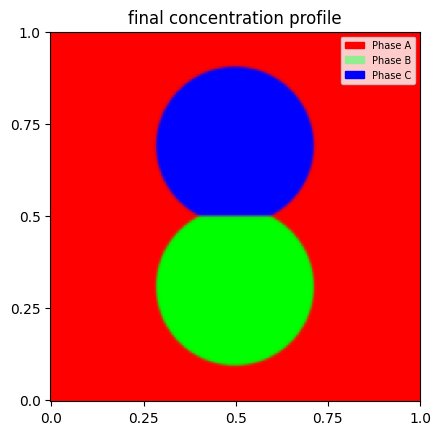

In [25]:
with open(f"result-new-new/gammaBC-{gamma_bc}/data.log", "w") as f1:
    with redirect_stdout(f1):
        print(f"delta : {delta}")
        print(f"gamma[AB, BC, CA] : {gamma}")
        print(f"A[a, b ,c] : {A}")
        print(f"experimental A: [{jnp.sqrt(2)*Lambda*(Aa + Ab + 2*C)/6}, {jnp.sqrt(2)*Lambda*(Ac + Ab + 2*C)/6}, {jnp.sqrt(2)*Lambda*(Aa + Ac + 2*C)/6}]")
        print(f"h : {h}")
        print(f"epsilon : {eps}")
        print(f"R : {R}")
        print(f"N : {N}\n")

        print(P1_ind)
        print("P1: ",P1)
        print("P2: ",P2)
        print("P3: ",P3)

        print("------------------------------------------------------\n")
        print(f"Theoretical contact angle : {np.degrees(np.arccos(gamma_bc/(gamma_ab+gamma_ca)))}")
        print(f"Experimental contact angle : {contact_angle}")
        print(f"[Lower limit, Upper limit] : [{low}, {up}]")
        print("------------------------------------------------------\n")

        lp.print_stats()

plot_RGB(ua, ub, uc, name=f"final concentration profile", issavefig=True, show=True)